# Source Code: Soil Classification Article - Oxisol and Inceptisol

## Universidade Tecnologica Federal do Parana, (Pato Branco | Curitiba) , Brazil

### Author: Juliano Tiago Rinaldi (Master's degree student in Electrical Engineering)

### Guiding Teachers:
 - Dalcimar Casanova (Master's advisor - UTFPR Pato Branco)
 - Heitor S. Lopes (Teacher - UTFPR Curitiba)
 - Thiago H. Silva (Teacher - UTFPR Curitiba)



# Classification Model

### Checking GPU running

In [ ]:
# Check GPU
!nvidia-smi
# Check CUDA installed
!nvcc --version

Fri May  5 11:16:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download Dataset/Images

In [ ]:
# Download files
!wget -nv --no-check-certificate 'https://drive.google.com/uc?id=1mQv0nVgEJxSG9isgnYk9FIUIDeCtI1rV&authuser=0&export=download' -O 'Dataset256x256-Teste.csv'
!wget -nv --no-check-certificate 'https://drive.google.com/uc?id=1FGRHjh9YJLdCNgXTdrzp5pve9qGcuk00&authuser=0&export=download' -O 'Dataset256x256-Treino.csv'

!wget -nv --no-check-certificate 'https://drive.google.com/uc?id=1Hpb9ok66SjWG9JDtEm7Kh2XmgJcGSahh&authuser=0&export=download&confirm=t&uuid=2d8b1e05-957d-4fed-a0dd-5dbb47a733e5' -O 'teste-solo-256x256.zip'
!wget -nv --no-check-certificate 'https://drive.google.com/uc?id=1GBJdR4bb2oxxxiJq4d5WR9ckvDCyz4QM&authuser=0&export=download&confirm=t&uuid=be6e6bb3-815d-49b7-b574-7738441df5b0' -O 'treinamento-solo-256x256.zip'


2023-05-05 11:16:06 URL:https://doc-0o-74-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/rt5cqbglp7ejjtkc73sfe4tr8d5gmmhg/1683285300000/17383397263719812770/*/1mQv0nVgEJxSG9isgnYk9FIUIDeCtI1rV?e=download&uuid=ad010011-96ab-4ac8-8efb-ab3faf05e373 [240965/240965] -> "Dataset256x256-Teste.csv" [1]
2023-05-05 11:16:07 URL:https://doc-14-74-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/66v0q7gva4anluaeu8mbodem3j5t34v6/1683285300000/17383397263719812770/*/1FGRHjh9YJLdCNgXTdrzp5pve9qGcuk00?e=download&uuid=ea7624a7-e135-4008-918f-8c83d4ca212d [564262/564262] -> "Dataset256x256-Treino.csv" [1]
2023-05-05 11:16:16 URL:https://doc-04-74-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/leg0faitkl7sd0s938dn364majbr2215/1683285300000/17383397263719812770/*/1Hpb9ok66SjWG9JDtEm7Kh2XmgJcGSahh?e=download&uuid=2d8b1e05-957d-4fed-a0dd-5dbb47a733e5 [334456145/334456145] -> "teste-solo-256x256.zip" [1]
2023-05-05 11:16:29 URL:ht

In [ ]:
# Extracting files
!unzip -oq teste-solo-256x256.zip
!rm teste-solo-256x256.zip

!unzip -oq treinamento-solo-256x256.zip
!rm treinamento-solo-256x256.zip

## Import Libraries

In [ ]:
# Imports Local

import numpy as np # Array
import random # Randomization
import pandas as pd # Data analysis, Import, etc.
from matplotlib import pyplot as plt # Matplotlib Plot
# Matplotlib in same windows
%matplotlib inline
from tqdm import tqdm # Iterable with loading
import cv2 # Image process

In [ ]:
from google.colab.patches import cv2_imshow # Images on Colab
from sklearn.model_selection import train_test_split # Split data
import tensorflow as tf # Machine learning
import keras # Machine learning
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score # Metrics

## Config GPU as Principal

In [ ]:
# Set GPU with as principal
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)
keras.backend.set_session(sess)

## Loading dataset

In [ ]:
# Loading dataset
df_train = pd.read_csv('Dataset256x256-Treino.csv')
df_test = pd.read_csv('Dataset256x256-Teste.csv')

## Function load image

In [ ]:
# Loading image to object
def image_processing(dir_name_base, imageFilePath, dimensionX, dimensionY, qtd_canal_color):
    image = cv2.imread(f'{dir_name_base}/{imageFilePath}')
    return image

# Loading images from dataset

In [ ]:
# Set image dimensions
imageDimensionX = 256
imageDimensionY = 256

# Path dir train
dir_name_train = "treinamento-solo-256x256"
# Path dir test
dir_name_test = "teste-solo-256x256"

# Random dataframe
df_train_random = df_train.sample(frac=1, random_state=1, ignore_index=True)
df_test_random = df_test.sample(frac=1, random_state=1, ignore_index=True)

# Amount of images
print(f'Total de imagens no Dataset Treino: {len(df_train_random.arquivo)}\n')
print(f'Total de imagens no Dataset Teste: {len(df_test_random.arquivo)}\n')

# Total used images to train/test
qtd_imagens = 8930
# Amount of channels (colors)
qtd_canal_color = 3

Total de imagens no Dataset Treino: 8930

Total de imagens no Dataset Teste: 3843



In [ ]:
# Images array to load for training
image_list_train = []

for imageFilePath in tqdm(df_train_random.arquivo.tolist()[:qtd_imagens]):
    image_list_train.append([imageFilePath, image_processing(dir_name_train, imageFilePath, imageDimensionX, imageDimensionY, qtd_canal_color)])

100%|██████████| 8930/8930 [00:22<00:00, 391.94it/s]


In [ ]:
# Images array to load for test
image_list_test = []

for imageFilePath in tqdm(df_test_random.arquivo.tolist()[:qtd_imagens]):
    image_list_test.append([imageFilePath, image_processing(dir_name_test, imageFilePath, imageDimensionX, imageDimensionY, qtd_canal_color)])

100%|██████████| 3843/3843 [00:09<00:00, 387.62it/s]


# Transformation of images to array data

In [ ]:
# Transformation (training)
X_train =  np.array([linha[1] for linha in image_list_train])
print(f'Shape X_train: {X_train.shape}')

Y_train_class = np.array(df_train_random['class'].tolist()[:qtd_imagens])
print(f'Shape Y_train_class: {Y_train_class.shape}')

del image_list_train

Shape X_train: (8930, 256, 256, 3)
Shape Y_train_class: (8930,)


In [ ]:
# Transformation (test)
X_test = np.array([linha[1] for linha in image_list_test])
print(f'Shape X_test: {X_test.shape}')

Y_test_class = np.array(df_test_random['class'].tolist()[:qtd_imagens])
print(f'Shape Y_test_class: {Y_test_class.shape}')

del image_list_test

Shape X_test: (3843, 256, 256, 3)
Shape Y_test_class: (3843,)


# Model: create a new model from training

In [ ]:
# This source is commented on because below there is a load source code with a model compiled
# If you need to create a new model, please, uncomment the code below.

# resnet_model = Sequential()

# pretrained_model= tf.keras.applications.ResNet50(include_top=False,
#                    input_shape=(imageDimensionX, imageDimensionY, qtd_canal_color),
#                    pooling='avg',classes=1,
#                    weights='imagenet')

# for layer in pretrained_model.layers:
#         layer.trainable=False

# resnet_model.add(pretrained_model)
# resnet_model.add(tf.keras.layers.Flatten())
# resnet_model.add(tf.keras.layers.Dense(512, activation='relu'))
# resnet_model.add(tf.keras.layers.Dropout(0.5))
# resnet_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# resnet_model.summary()

In [ ]:
# opt = tf.keras.optimizers.Adam()
# resnet_model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

# history = resnet_model.fit(X_train, Y_train_class, validation_split=0.2, epochs=100, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

# resnet_model.save('filename-model.h5')

# Models compiled

In [ ]:
# Download to model compiled
!wget -nv --no-check-certificate 'https://drive.google.com/uc?id=1n8bfp5-V5BlrVk8NPcHSFR7a2jZoTbth&authuser=2&export=download' -O '28-epoch-accuracy-93.75.h5'

#!wget -nv --no-check-certificate 'https://drive.google.com/uc?id=1gm7GtY53b-u4v3CE8io9PJD4I5ME44Jc&authuser=2&export=download' -O '47-epoch-accuracy-95.09.h5'
#!wget -nv --no-check-certificate 'https://drive.google.com/uc?id=1-2BIGk1Pxqq4ajo97u6yaLUaPB76rNWo&authuser=2&export=download' -O '48-epoch-accuracy-93.35.h5'
#!wget -nv --no-check-certificate 'https://drive.google.com/uc?id=1M78_EwVOLm0EMWZKHrarRIQFgnM43EgP&authuser=2&export=download' -O '48-epoch-accuracy-94.93.h5'
#!wget -nv --no-check-certificate 'https://drive.google.com/uc?id=1msSu_IeBrSrAJDYpeAIMvIDhu4oYnO6D&authuser=2&export=download' -O '53-epoch-accuracy-95.00.h5'
#!wget -nv --no-check-certificate 'https://drive.google.com/uc?id=1-4ITVyftPqV7DhzjFv7jCuGRFdtiYcw4&authuser=2&export=download' -O '54-epoch-accuracy-95.38.h5'
#!wget -nv --no-check-certificate 'https://drive.google.com/uc?id=1h6n6sttTt67ad_k_Ms9svu2HPu6Xb4xW&authuser=2&export=download' -O '56-epoch-accuracy-95.63.h5'
#!wget -nv --no-check-certificate 'https://drive.google.com/uc?id=14avllYbAkQ8MGHNC3c0ykKCITYl650j2&authuser=2&export=download' -O '58-epoch-accuracy-95.67.h5'
#!wget -nv --no-check-certificate 'https://drive.google.com/uc?id=1GgO9PCu5UnAuoza3p-faLAl6GjAh3QEl&authuser=2&export=download' -O '61-epoch-accuracy-95.76.h5'
#!wget -nv --no-check-certificate 'https://drive.google.com/uc?id=1u5XAo-TXqHXuNZWOxQb4a9IHohGgTdKj&authuser=2&export=download' -O '63-epoch-accuracy-95.67.h5'

2023-05-05 11:17:32 URL:https://doc-04-74-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/c30umoghevir9169oho9hqrbcra096fm/1683285375000/17383397263719812770/*/1n8bfp5-V5BlrVk8NPcHSFR7a2jZoTbth?e=download&uuid=927e4329-eb32-4690-aabb-f27522a303a2 [94709464/94709464] -> "28-epoch-accuracy-93.75.h5" [1]


In [ ]:
# Models array
resnet_models = []

# Selecting model to loading
resnet_model1 = tf.keras.models.load_model('28-epoch-accuracy-93.75.h5')
resnet_models.append(resnet_model1)

In [ ]:
# Executing accuracy metrics on models
accuracies = []
for model in resnet_models:
  prediction = model.predict(X_test)
  prediction_rouded = prediction.round().reshape(len(prediction),).astype(int)
  accuracy = accuracy_score(prediction_rouded, Y_test_class)
  accuracies.append(accuracy)


121/121 [==============================] - 23s 108ms/step


In [ ]:
# Result accuracy metrics
accuracies

[0.9352068696330992]

In [ ]:
# Calculating mean
print(np.mean(accuracies))
# Calculating standard deviation
print(np.std(accuracies))

0.9352068696330992
0.0


# Analyzing metrics results

In [ ]:
prediction = resnet_model1.predict(X_test)
prediction_rouded = prediction.round().reshape(len(prediction),).astype(int)

accuracy = accuracy_score(prediction_rouded, Y_test_class)
precision = precision_score(prediction_rouded, Y_test_class)
recall = recall_score(prediction_rouded, Y_test_class)
f1 = f1_score(prediction_rouded, Y_test_class)

df_model = pd.DataFrame(index=['Transfer-Learning'], columns=['Accuracy', 'Precision', 'Recall', 'F1'])
df_model['Accuracy'] = accuracy
df_model['Precision'] = precision
df_model['Recall'] = recall
df_model['F1'] = f1

df_model

121/121 [==============================] - 13s 108ms/step


,Accuracy,Precision,Recall,F1
Transfer-Learning,0.935207,0.901899,0.964467,0.932134


In [ ]:
# Metrics results
print("Métricas")
print(classification_report(prediction_rouded, Y_test_class))

# Confusion matrix
print("Matriz de Confusão")
print(confusion_matrix(prediction_rouded, Y_test_class))

Métricas
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      2070
           1       0.90      0.96      0.93      1773

    accuracy                           0.94      3843
   macro avg       0.93      0.94      0.94      3843
weighted avg       0.94      0.94      0.94      3843

Matriz de Confusão
[[1884  186]
 [  63 1710]]


# Predicted vs. Actual classification view

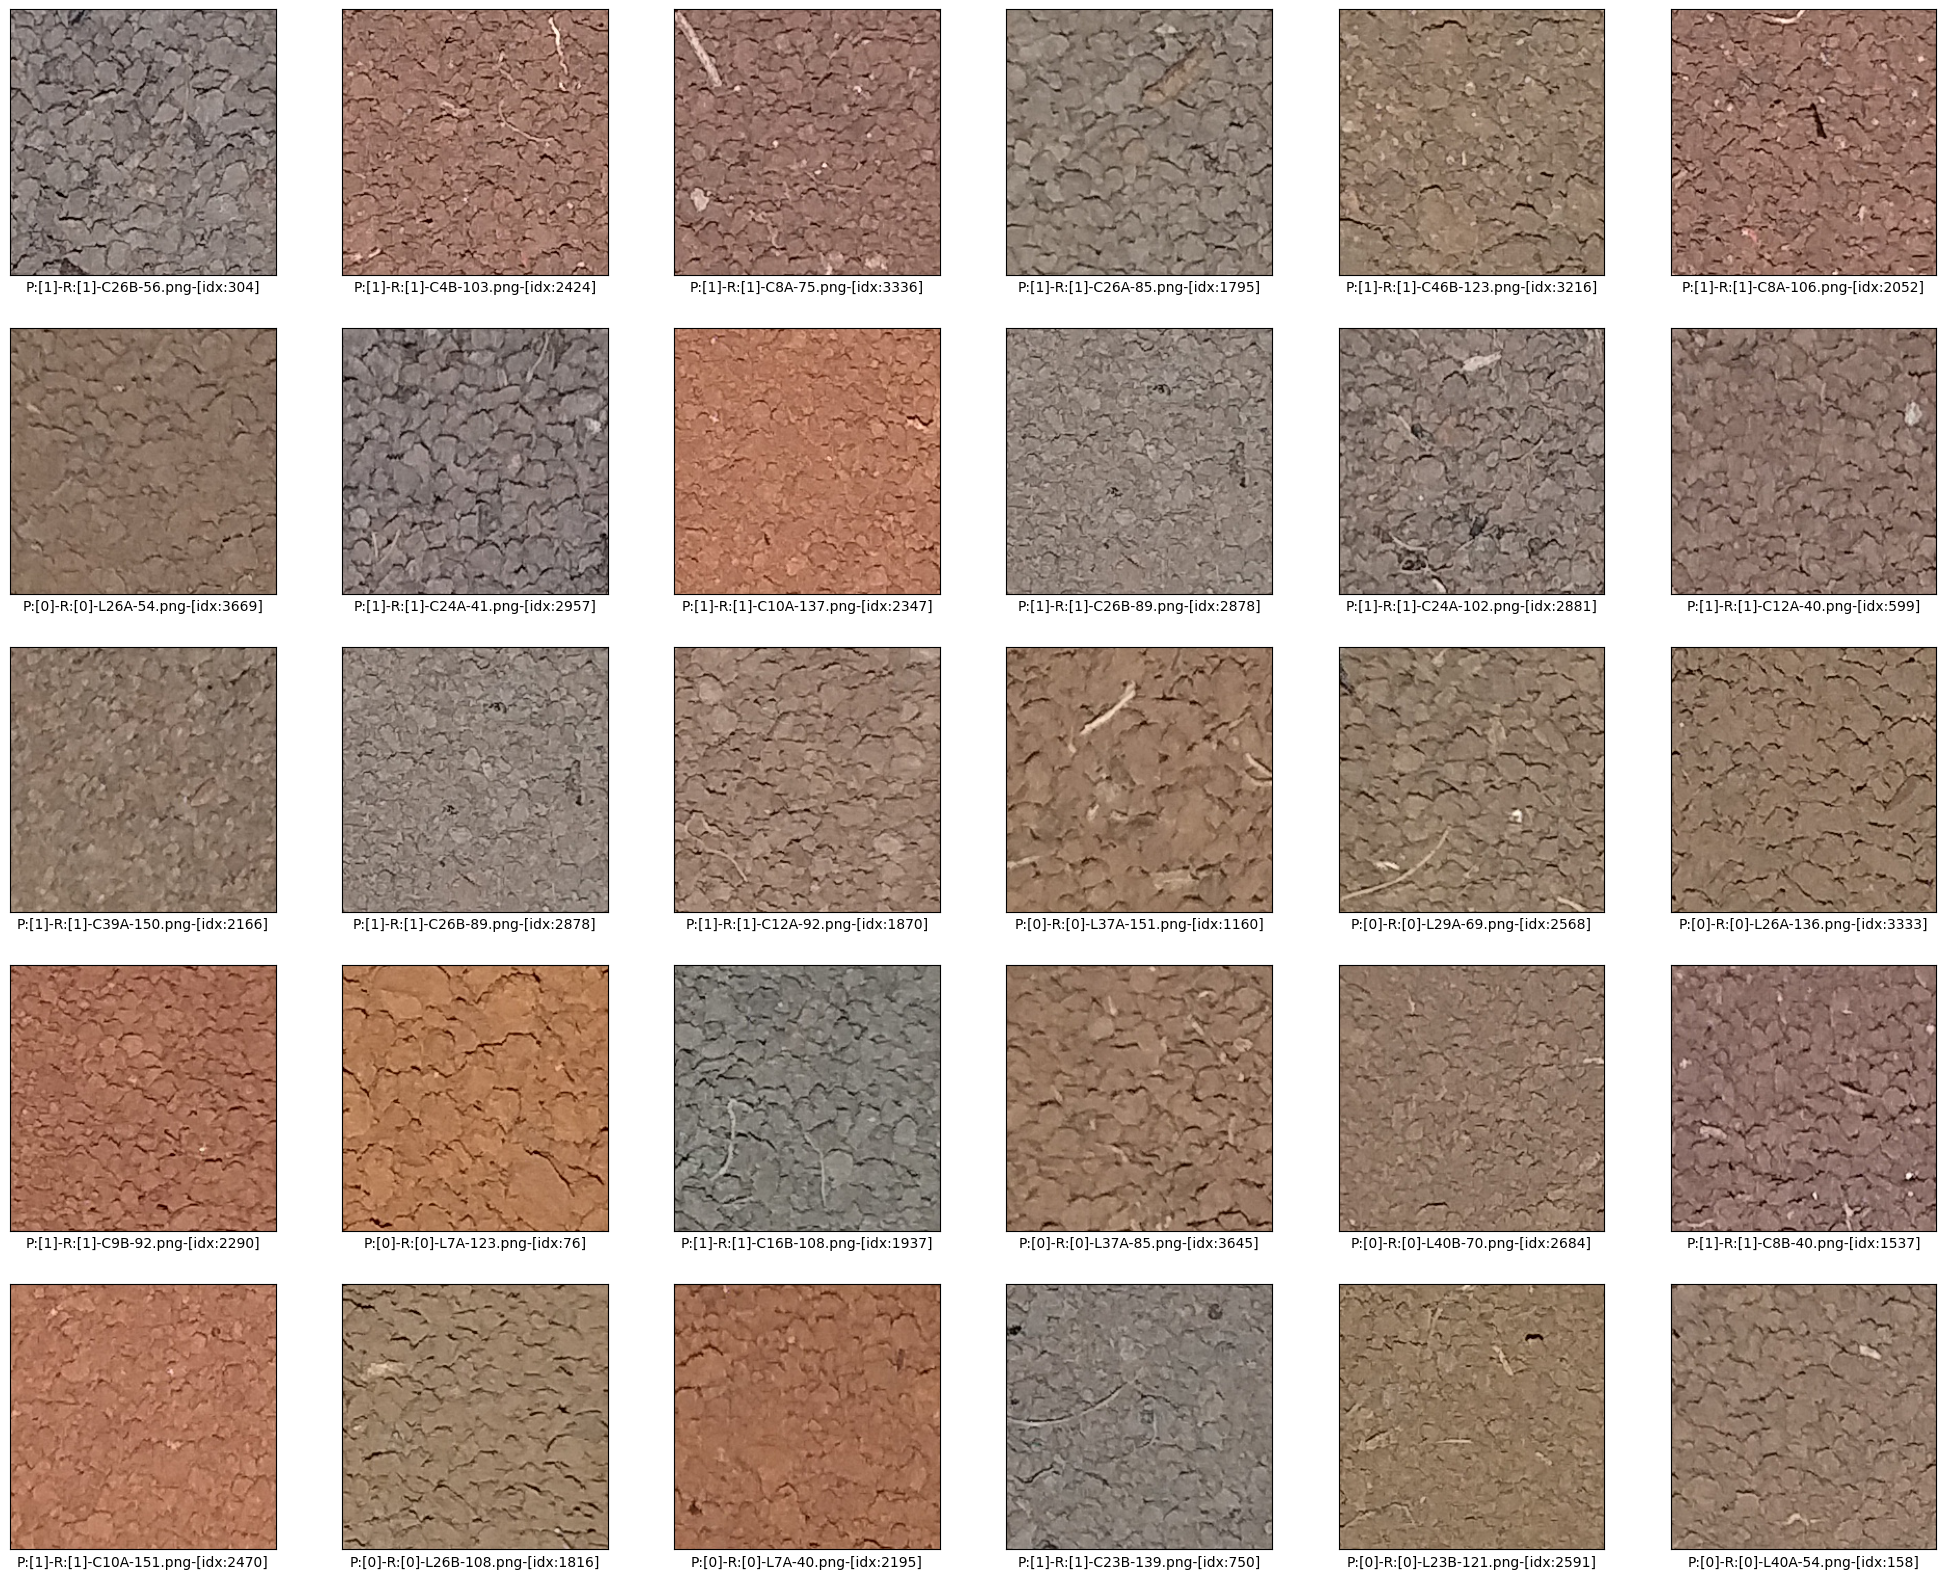

In [ ]:
from random import randrange

class_names = ['Latosolo', 'Cambisolo']

# Amount of images to view
amostras_view = 30
#amostras_view = [2, 3, 10, 11, 12, 13, 14, 15, 20, 30, 40, 50, 100, 200, 1000, 1500, 3000]

plt.figure(figsize=(25, 20))
for index in range(amostras_view):
    rand_num = randrange(len(X_test))
    imagem = cv2.cvtColor(X_test[rand_num], cv2.COLOR_BGR2RGB)
    predictText=f'P:[{prediction_rouded[rand_num]}]'
    realText=f'R:[{Y_test_class[rand_num]}]'
    plt.subplot(5,6,index+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(imagem)
    plt.xlabel(f'{predictText}-{realText}-{df_test_random["arquivo"][rand_num]}-[idx:{rand_num}]')

plt.show()

In [ ]:
# Print DataFrame - Analyzing classification
# [0] = L (Latossolo = Oxisol)
# [1] = C (Cambissolo = Inceptisol)
df_test_amostra_original = df_test_random.loc[:, ['amostra', 'class']]
df_test_amostra_original = df_test_amostra_original.drop_duplicates(subset=['amostra', 'class'])
df_test_amostra_original

,amostra,class
0,C10,1
1,L29,0
2,L26,0
3,C39,1
4,C4,1
5,C9,1
7,C12,1
8,C24,1
9,C23,1
10,C51,1


In [ ]:
# Adding correct and incorrect results
# -1: Sum of incorrect results of classification to each sample
# 1: Sum of correct results of classification to each sample

# Print DataFrame - Analyzing classification
# L (Latossolo = Oxisol)
# C (Cambissolo = Inceptisol)

df_test_random['predict'] = prediction_rouded
df_likelihood_test = df_test_random.loc[:, ['amostra']]

condicao = lambda row: 1 if row['class'] == row['predict'] else -1

condicaoAcerto = lambda row: 1 if row['class'] == row['predict'] else 0
condicaoErro = lambda row: 0 if row['class'] == row['predict'] else 1

df_likelihood_test['likelihood'] = df_test_random.apply(condicao, axis=1)
df_likelihood_test['acertos'] = df_test_random.apply(condicaoAcerto, axis=1)
df_likelihood_test['erros'] = df_test_random.apply(condicaoErro, axis=1)

df_likelihood_test_aggredate = df_likelihood_test.groupby(['amostra', 'likelihood'])['likelihood'].agg('sum').unstack()

# Result of likelihood - View more below (Majority votes)
df_likelihood_test_winner = df_likelihood_test.groupby('amostra').agg({'likelihood': 'sum'}).reset_index()

df_likelihood_test_aggredate

likelihood,-1,1
amostra,,
C10,-23.0,104.0
C12,-20.0,107.0
C16,-7.0,121.0
C23,-11.0,117.0
C24,-2.0,124.0
C26,NaN,124.0
C3,NaN,125.0
C37,NaN,127.0
C39,NaN,125.0


In [ ]:
# Adding correct and incorrect results
# erros: incorrect results of classification to each sample
# acertos: correct results of classification to each sample
# total: amount of each sample
# %.acertos: percent(%) of correct classification of each sample

# Print DataFrame - Analyzing classification
# L (Latossolo = Oxisol)
# C (Cambissolo = Inceptisol)

df_likelihood_test_acertos_erros = df_likelihood_test.groupby(['amostra'], as_index=False)[['acertos', 'erros']].apply('sum')
df_likelihood_test_acertos_erros['total'] = df_likelihood_test_acertos_erros['erros'] + df_likelihood_test_acertos_erros['acertos']
df_likelihood_test_acertos_erros['%.acertos'] = df_likelihood_test_acertos_erros['acertos'] / df_likelihood_test_acertos_erros['total']

#df_likelihood_test_acertos_erros
df_likelihood_test_acertos_erros['cambissolo'] = df_likelihood_test_acertos_erros['%.acertos'][:15]
df_likelihood_test_acertos_erros['latossolo'] = df_likelihood_test_acertos_erros['%.acertos'][15:]
df_likelihood_test_acertos_erros

,amostra,acertos,erros,total,%.acertos,cambissolo,latossolo
0,C10,104,23,127,0.818898,0.818898,NaN
1,C12,107,20,127,0.842520,0.842520,NaN
2,C16,121,7,128,0.945312,0.945312,NaN
3,C23,117,11,128,0.914062,0.914062,NaN
4,C24,124,2,126,0.984127,0.984127,NaN
5,C26,124,0,124,1.000000,1.000000,NaN
6,C3,125,0,125,1.000000,1.000000,NaN
7,C37,127,0,127,1.000000,1.000000,NaN
8,C39,125,0,125,1.000000,1.000000,NaN
9,C4,102,26,128,0.796875,0.796875,NaN


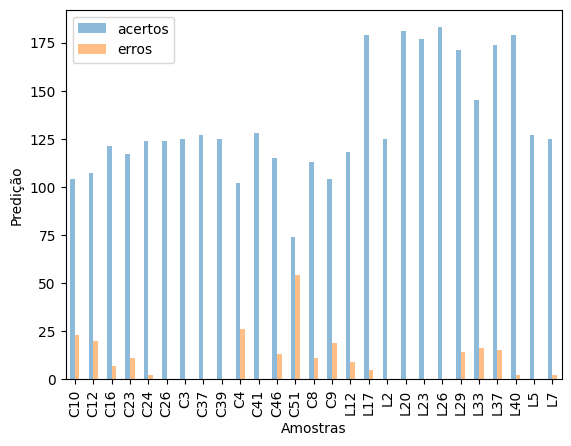

In [ ]:
# Print chart - acertos x erros (correct x incorrect)
# L (Latossolo = Oxisol)
# C (Cambissolo = Inceptisol)

df_agrupado = df_likelihood_test_acertos_erros.groupby('amostra').mean()
df_agrupado = df_agrupado.drop('total', axis=1).drop('%.acertos', axis=1).drop('cambissolo', axis=1).drop('latossolo', axis=1)
df_agrupado.plot(kind='bar', alpha=0.5, xlabel='Amostras', ylabel='Predição')
plt.show()

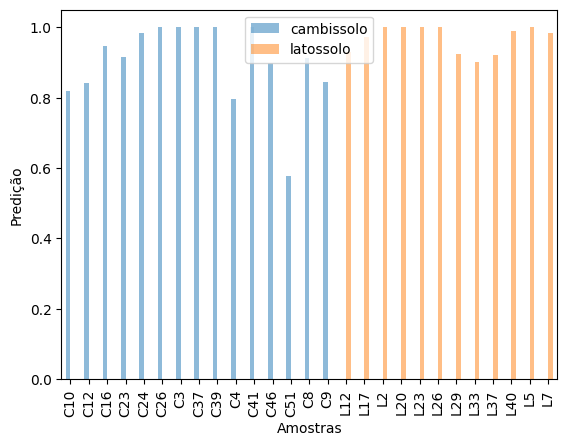

In [ ]:
# Print chart - % of prediction classification
# L (Latossolo = Oxisol)
# C (Cambissolo = Inceptisol)

df_agrupado = df_likelihood_test_acertos_erros.groupby('amostra').mean()
df_agrupado = df_agrupado.drop('total', axis=1).drop('acertos', axis=1).drop('erros', axis=1).drop('%.acertos', axis=1)
df_agrupado.plot(kind='bar', alpha=0.5, xlabel='Amostras', ylabel='Predição')
plt.show()

# Result of likelihood (Majority votes)

In [ ]:
# Print DataFrame - Analyzing classification
# L (Latossolo = Oxisol)
# C (Cambissolo = Inceptisol)

df_likelihood_test_winner

,amostra,likelihood
0,C10,81
1,C12,87
2,C16,114
3,C23,106
4,C24,122
5,C26,124
6,C3,125
7,C37,127
8,C39,125
9,C4,76
